# BOExplorer
### Diary visualization graphics

#### 1. Imports

In [53]:
from typing import Callable, Set, Generator, Iterable, Dict, List
import datetime
import collections
import itertools
import functools
import httplib2
import locale
import json

import matplotlib
from matplotlib import pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go # Import the graphical object

from helpers import helpers
from helpers.helpers import partialmap
from helpers import boe

In [40]:
import pymysql

def create_db_wrapper(db_host, db_database, db_user, db_password):
    def caller(f, *args, **kwargs):
        keyword_args = dict(kwargs)
        keyword_args.update({
            'host': db_host,
            'database': db_database,
            'user': db_user,
            'password': db_password
        })
        return f(*args, **keyword_args)
    return caller

def execute_query(host, user, password, database, query) -> None:
    '''Execute an SQL query.'''
    
    connection = pymysql.connect(
        host=host,
        user=user,
        password=password,
        database=database)

    with connection:
        with connection.cursor() as cursor:
            status = cursor.execute(query)
            if status == 0:
                r = None
            else:
                r = cursor.fetchall() # just one query is excuted

        connection.commit()
    return r

def get_date_range(host, user, password, database):
    '''Get minimum and maximum dates in the database.'''
    
    q = 'select min(date) as start, max(date) as end from boe_diary_entry;'
    start, end = execute_query(host, user, password, database, q)[0]
    return start, end

def get_entries_by_department_for_date(host, user, password, database, date):
    '''Get the count of entries per department and section, for a specific date.'''
    
    q = f'''select boe_diary_section.name, department, count(department) as count
            from boe_diary_entry, boe_diary_section
            where boe_diary_section.id = boe_diary_entry.section and boe_diary_entry.date = '{date:%Y-%m-%d}'
            group by department;
    '''

    data = execute_query(host, user, password, database, q)
    return data

def get_entries_for_date(host, user, password, database, date):
    '''Get all entries per department and section, for a specific date.'''
    columns = 'id, title, type_desc, section, department, economic_impact'
    q = f"select {columns} from boe_diary_entry where date = '{date:%Y-%m-%d}';"

    data = execute_query(host, user, password, database, q)
    Entry = collections.namedtuple('Entry', ' '.join(columns.split(', ')))
    entries = [Entry(*d) for d in data]
    
    return entries


In [3]:
callwithdb = create_db_wrapper('localhost', 'boe', 'root', 'pass')

#### 2. Sample data

In [31]:
updated_data_file = 'entries_updated.json'

In [32]:
sample_data_file = 'entries_30_01_2021.json'

#### 3. Helper functions

In [8]:
def get_stats(entries, key):
    c = helpers.pipe(
        entries,
        partialmap(lambda x: x[key]),
        collections.Counter
    )
    return c

def print_overview(entries):
    print('\n', '-'*50, '\n Count by section', '\n', '-'*50)
    helpers.pipe(
        get_stats(entries, 'section'),
        lambda x: x.items(),
        partialmap(lambda x: (boe.code_to_section_name[x[0].lower()], x[1])),
        partialmap(lambda x: f' {x[0]}: {x[1]}'),
        '\n'.join,
        print
    )

    print('\n', '-'*50, '\n Count by department', '\n', '-'*50)
    helpers.pipe(
        entries,
        functools.partial(filter, lambda x: x['section'] not in ('4',)),
        functools.partial(get_stats, key='department'),
        lambda x: x.items(),
        partialmap(lambda x: f' {x[0]}: {x[1]}'),
        '\n'.join,
        print
    )

#### 3. Visualization functions

In [9]:
def vis_1(items, date=datetime.datetime.now()):
    plt.style.use('fivethirtyeight')
    plt.rcParams['font.size'] = '17'
    fig = plt.figure(figsize=(20,15))
    gs = matplotlib.gridspec.GridSpec(2, 2, width_ratios=[2, 1])

    section_c = collections.Counter(itertools.chain((item.get('section') for item in items)))
    sections = sorted(section_c.items(), key=lambda x: x[1])

    department_c = collections.Counter(itertools.chain((item.get('department') for item in items)))
    departments = [(f'{k} {v:-3} ', v) for k, v in department_c.items()]

    ax = fig.add_subplot(gs[0, 0])
    ax.barh([k for k, v in sections], [v for k, v in sections])
    ax.set_title(f'Se registraron {sum(section_c.values())} entradas en distintas secciones . . .', fontsize=16)
    ax.set_ylabel('Sección')
    ax.set_xlabel('Número de entradas')

    ax = fig.add_subplot(gs[1, 0])
    ax.barh([k for k, v in sections], [v for k, v in sections], color='lightgrey')
    ax.set_title(f'. . . de las cuales con gasto económico asociado', fontsize=16)
    ax.set_ylabel('Sección')
    ax.set_xlabel('Número de entradas')

    ax = fig.add_subplot(gs[:,1])
    ax.barh([k for k, v in departments], [v for k, v in departments])
    ax.set_title(f'Desglose por departamento', fontsize=16)
    ax.set_xlabel('Número de entradas')
    ax.set_frame_on(False)

    fig.suptitle(f'Resumen de la actividad en el BOE para el día {date:%d del %m, %Y}', fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
def vis_2(items, date=datetime.datetime.now()):
    plt.style.use('fivethirtyeight')
    plt.rcParams['font.size'] = '15'
    fig = plt.figure(figsize=(17,14))
    gs = matplotlib.gridspec.GridSpec(2, 2, width_ratios=[3, 2])

    sections = {k: 0 for k in boe.code_to_section_name.keys()}
    section_c = collections.Counter(itertools.chain((item.get('section') for item in items)))
    sections = section_c

    sections_sorted = sorted(sections.items(), key=lambda x: x[1])
    section_labels = [f'{boe.code_to_section_name[k.lower()]} {v:-3}' for k, v in sections_sorted]

    department_c = collections.Counter(itertools.chain((item.get('department') for item in items)))
    departments = [(f'{k} {v:-3} ', v) for k, v in department_c.items()]

    ax0 = fig.add_subplot(gs[0, 0])
    ax0.barh(section_labels, [v for k, v in sections_sorted])
    ax0.set_title(f'Se registraron {sum(section_c.values())} entradas en distintas secciones . . .', fontsize=16)
    ax0.set_xlabel('Número de entradas')

    ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)
    ax1.set_title(f'. . . con un gasto económico', fontsize=16)
    ax1.axis('off')
    for l, _ in enumerate(section_labels):
        ax1.text(0, l, '0 entradas con un monto total de 30€')

    fig.suptitle(f'Resumen de la actividad en el BOE para el día {date:%d del %m, %Y}', fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
def vis_4(items):
    sections = {k: 0 for k in boe.code_to_section_name.keys()}
    section_c = collections.Counter(itertools.chain((item.get('section') for item in items)))
    sections = section_c
    sections_sorted = sorted(sections.items(), key=lambda x: x[1])
    legend_labels = [
        #boe.code_to_section_name[k.lower()]
        k
        for k, v
        in sections_sorted
    ]

    fig, ax = plt.subplots(figsize=(5,8))
    ax.margins(x=1)
    ax.stackplot(
        [0,1],
        list([d[1], d[1]] for d in sections_sorted),
        labels=legend_labels)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), title='Section', loc='upper right')

def vis_5(items):
    init_notebook_mode(connected=True)
    section_c = collections.Counter(itertools.chain((item.get('section') for item in items)))
    department_c = collections.Counter(itertools.chain((item.get('department') for item in items)))
    
    # plotly will require both nodes and links to be integers, so they need to be indexed
    def get_source_and_targets(items, id_to_section_name):
        sections = collections.Counter(itertools.chain((item.get('section') for item in items)))
        sections_sorted = sorted(sections.items(), key=lambda x: -x[1])
        sorted_section_names = [id_to_section_name[x.lower()] for x,y in sections_sorted]
        department_to_section = dict([(d['department'], id_to_section_name[d['section'].lower()]) for d in items])
        sorted_links = sorted(department_to_section.items(), key=lambda d: sorted_section_names.index(d[1]))

        name_2_id = {id_to_section_name[d.lower()]:i for i, d in enumerate(x[0] for x in sections_sorted)}
        name_2_id.update({d:len(sections_sorted)+i for i, d in enumerate(set(department_to_section.keys()))})

        return [(name_2_id[y], name_2_id[x]) for x,y in sorted_links], {v: k for k,v in name_2_id.items()}

    section_department_pairs, id_2_name = get_source_and_targets(items, boe.code_to_section_name)
    
    labels = [y for x, y in sorted(id_2_name.items(), key=lambda x: x[0])]
    section_name_to_id = {v: k for k, v in boe.code_to_section_name.items()}
    for i in range(len(labels)):
        if labels[i] in department_c:
            labels[i] = f'{labels[i]} ({department_c[labels[i]]})'
        else:
            labels[i] = f'{labels[i]} ({section_c[section_name_to_id[labels[i]].upper()]})'

    fig = go.Figure( 
        data=[go.Sankey( # The plot we are interest
            # This part is for the node information
            node = dict( 
                label = labels
            ),
            # This part is for the link information
            link = dict(
                source = [x for x,y in section_department_pairs],
                target = [y for x,y in section_department_pairs],
                value = [department_c[id_2_name[y]] for x,y in section_department_pairs]
            ))])

    # With this save the plots 
    #plot(fig,
    # image_filename='sankey_plot_1', 
    #  image='png', 
    #   image_width=1000, 
    #    image_height=600
    #)
    fig.update_layout(
    autosize=False,
    width=1000,
    height=1400,)
    fig.show()

In [110]:
boe.code_to_section_name

{'1': 'disposiciones generales',
 '2': 'autoridades y personal',
 '2a': 'nombramientos situaciones e incidencias',
 '2b': 'oposiciones y concursos',
 '3': 'otras secciones',
 '4': 'administración de justicia',
 '5': 'anuncios',
 '5a': 'licitaciones públicas y adjudicaciones',
 '5b': 'otros anuncios particulares',
 '5c': 'anuncios particulares',
 't': 'tribunal constitucional'}

In [113]:
code_to_section_name = {'1': 'disposiciones generales',
 '2': 'autoridades y personal',
 '2a': 'nombramientos situaciones    \ne incidencias',
 '2b': 'oposiciones y concursos',
 '3': 'otras secciones',
 '4': 'administración de justicia',
 '5': 'anuncios',
 '5a': 'licitaciones públicas    \ny adjudicaciones',
 '5b': 'otros anuncios particulares',
 '5c': 'anuncios particulares',
 't': 'tribunal constitucional'}

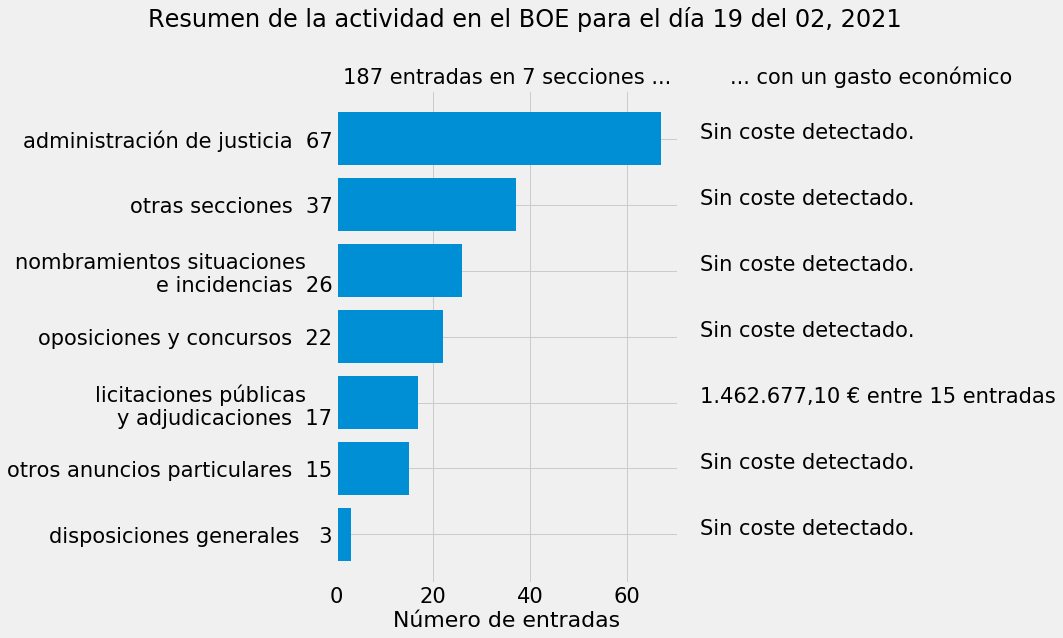

In [118]:
def vis_6(items, date=datetime.datetime.now()):
    locale.setlocale(locale.LC_ALL,"")
    plt.style.use('fivethirtyeight')
    plt.rcParams['font.size'] = '21'
    fig = plt.figure(figsize=(15, 17))
    gs = matplotlib.gridspec.GridSpec(2, 2, width_ratios=[3, 3])

    sections = {k: 0 for k in boe.code_to_section_name.keys()}
    section_c = collections.Counter(itertools.chain((item.section for item in items)))
    sections = section_c

    sections_sorted = sorted(sections.items(), key=lambda x: x[1])
    section_labels = [f'{code_to_section_name[k.lower()]} {v:-3}' for k, v in sections_sorted]

    ax0 = fig.add_subplot(gs[0, 0])
    ax0.barh(section_labels, [v for k, v in sections_sorted])
    ax0.set_title(f'{sum(section_c.values())} entradas en {len(section_c)} secciones ...', fontsize=21)
    ax0.set_xlabel('Número de entradas', fontsize=22)

    ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)
    ax1.set_title(f'... con un gasto económico', fontsize=21)
    ax1.axis('off')
    for l, _ in enumerate(section_labels):
        with_cost = tuple(filter(lambda d: d.section == sections_sorted[l][0] and d.economic_impact > 0, items))
        cost = sum(d.economic_impact for d in with_cost)
        
        if cost > 0:
            cost_text = locale.currency(cost, grouping=True)
            ax1.text(0, l, f'{cost_text} entre {len(with_cost)} entradas', fontsize=21)
        else:
            ax1.text(0, l, f'Sin coste detectado.', fontsize=21)

    fig.suptitle(f'Resumen de la actividad en el BOE para el día {date:%d del %m, %Y}', fontsize=24)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig

fig = vis_6(updated_items, datetime.datetime(2021, 2, 19))

In [119]:
fig.savefig('diary_summary.png', bbox_inches = 'tight', pad_inches = .5)

#### 4. Execution

In [41]:
with open(sample_data_file, 'r') as f:
    items = json.load(f)

# with open(updated_data_file, 'r') as f:
#     updated_items = json.load(f)
updated_items = create_db_wrapper('63.250.57.15', 'boe', 'boeetl', 'frbey37892#@edc7')(
    get_entries_for_date,
    date=datetime.datetime(2021, 2, 19))

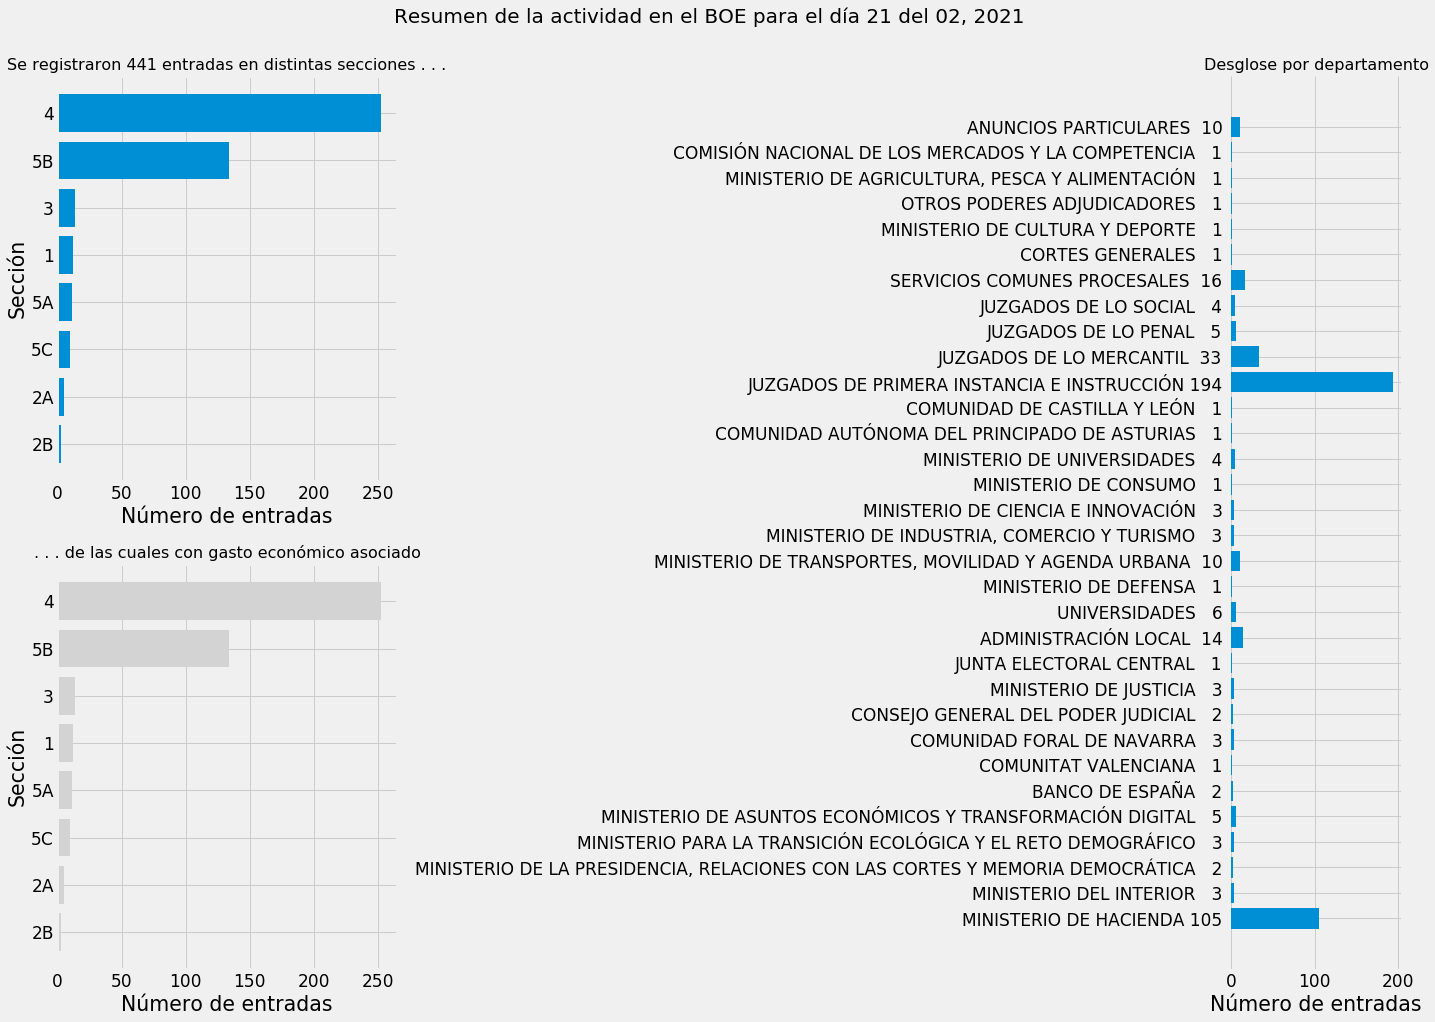

In [34]:
vis_1(items)

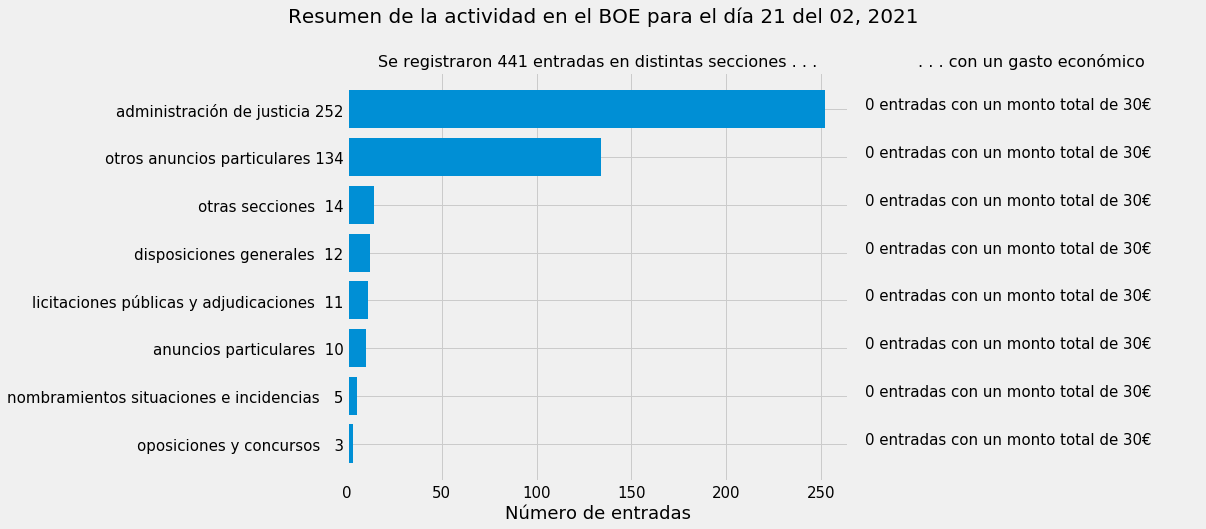

In [12]:
vis_2(items)

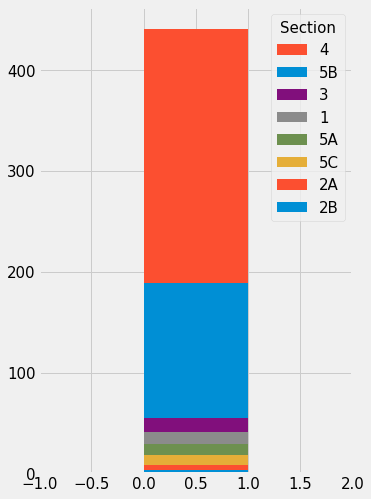

In [13]:
vis_4(items)

In [14]:
vis_5(items)